In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import warnings

from scipy.stats import norm
from scipy import stats

from sklearn.feature_selection import mutual_info_classif, RFECV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (f1_score, 
                             roc_auc_score, 
                             precision_score, 
                             precision_recall_curve, 
                            )

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')
shap.initjs()

In [2]:
def get_metrics(y_test, preds):
    
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    
    return roc_auc_score(y_test, preds), precision[ix], recall[ix], fscore[ix], thresholds[ix]

#### 1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

https://archive.ics.uci.edu/ml/datasets/Arrhythmia

In [3]:
data = pd.read_csv('./data/arrhythmia.data', header=None)
data = data.sample(frac=1, random_state=42)

target: 1 - Normal, 0 - Arrhythmia

In [4]:
data['target'] = data.iloc[:, -1].where(data.iloc[:, -1] ==1, 0)

In [5]:
data['target'].value_counts()

1    245
0    207
Name: target, dtype: int64

In [6]:
data.shape

(452, 281)

Всего 281 признак, возьмём первые 15 признаков для модели:

In [7]:
data = pd.concat([data.iloc[:, :15], data['target']], axis=1)

#### 2. сделать обзорный анализ выбранного датасета

In [8]:
data.columns = ['age', 'sex', 'height', 'weight', 'QRS_interval', 'P-R_interval', 'Q-T_interval',
                'T_interval', 'P_interval', 'QRS_angle', 'T_angle', 'P_angle', 'QRST_angle',
                'J_angle', 'heart_rate', 'target']
data.head()

,age,sex,height,weight,QRS_interval,P-R_interval,Q-T_interval,T_interval,P_interval,QRS_angle,T_angle,P_angle,QRST_angle,J_angle,heart_rate,target
299,51,0,170,82,90,155,382,216,88,9,40,35,20,?,73,1
39,45,0,175,80,94,163,401,159,106,-57,-8,70,-48,?,53,0
336,31,1,165,56,74,199,384,142,100,110,11,54,92,?,75,0
332,42,0,188,91,113,213,358,220,107,91,39,84,79,?,78,0
153,34,1,167,60,63,164,396,139,84,49,10,64,31,?,54,0


Где 
- столбцы с **`_interval`** - средняя продолжительность, мсек
- с **`_angle`** - углы в градусах
- **heart_rate** - частота сердечных сокращений


- **target** = 1 - отсутствие аритмии

In [9]:
# Nan отсутствуют
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452 entries, 299 to 102
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           452 non-null    int64 
 1   sex           452 non-null    int64 
 2   height        452 non-null    int64 
 3   weight        452 non-null    int64 
 4   QRS_interval  452 non-null    int64 
 5   P-R_interval  452 non-null    int64 
 6   Q-T_interval  452 non-null    int64 
 7   T_interval    452 non-null    int64 
 8   P_interval    452 non-null    int64 
 9   QRS_angle     452 non-null    int64 
 10  T_angle       452 non-null    object
 11  P_angle       452 non-null    object
 12  QRST_angle    452 non-null    object
 13  J_angle       452 non-null    object
 14  heart_rate    452 non-null    object
 15  target        452 non-null    int64 
dtypes: int64(11), object(5)
memory usage: 60.0+ KB


In [10]:
# больше всего неизвестных
data['J_angle'].value_counts()

?       376
84        3
-157      2
-164      2
103       2
       ... 
23        1
-168      1
-137      1
121       1
154       1
Name: J_angle, Length: 70, dtype: int64

Но в столбцах с 10 по 14 есть пропуски со значением '?'.

Все остальные значения целочисленные.

- приведём столбцы к числовому типу с заменой '?' на NaN

In [11]:
for i in [10, 11, 12, 13, 14]:
    data.iloc[:, i] = pd.to_numeric(data.iloc[:, i], errors='coerce')

In [12]:
# все признаки числовые, кроме sex - бинарный, есть пропуски
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452 entries, 299 to 102
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           452 non-null    int64  
 1   sex           452 non-null    int64  
 2   height        452 non-null    int64  
 3   weight        452 non-null    int64  
 4   QRS_interval  452 non-null    int64  
 5   P-R_interval  452 non-null    int64  
 6   Q-T_interval  452 non-null    int64  
 7   T_interval    452 non-null    int64  
 8   P_interval    452 non-null    int64  
 9   QRS_angle     452 non-null    int64  
 10  T_angle       444 non-null    float64
 11  P_angle       430 non-null    float64
 12  QRST_angle    451 non-null    float64
 13  J_angle       76 non-null     float64
 14  heart_rate    451 non-null    float64
 15  target        452 non-null    int64  
dtypes: float64(5), int64(11)
memory usage: 60.0 KB


In [13]:
data.describe()

,age,sex,height,weight,QRS_interval,P-R_interval,Q-T_interval,T_interval,P_interval,QRS_angle,T_angle,P_angle,QRST_angle,J_angle,heart_rate,target
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,444.000000,430.000000,451.000000,76.000000,451.000000,452.000000
mean,46.471239,0.550885,166.188053,68.170354,88.920354,155.152655,367.207965,169.949115,90.004425,33.676991,36.150901,48.913953,36.716186,-13.592105,74.463415,0.542035
std,16.466631,0.497955,37.170340,16.590803,15.364394,44.842283,33.385421,35.633072,25.826643,45.431434,57.858255,29.346409,36.020725,127.220248,13.870684,0.498782
min,0.000000,0.000000,105.000000,6.000000,55.000000,0.000000,232.000000,108.000000,0.000000,-172.000000,-177.000000,-170.000000,-135.000000,-179.000000,44.000000,0.000000
25%,36.000000,0.000000,160.000000,59.000000,80.000000,142.000000,350.000000,148.000000,79.000000,3.750000,14.000000,41.000000,12.000000,-124.500000,65.000000,0.000000
50%,47.000000,1.000000,164.000000,68.000000,86.000000,157.000000,367.000000,162.000000,91.000000,40.000000,41.000000,56.000000,40.000000,-50.500000,72.000000,1.000000
75%,58.000000,1.000000,170.000000,79.000000,94.000000,175.000000,384.000000,179.000000,102.000000,66.000000,63.250000,65.000000,62.000000,117.250000,81.000000,1.000000
max,83.000000,1.000000,780.000000,176.000000,188.000000,524.000000,509.000000,381.000000,205.000000,169.000000,179.000000,176.000000,166.000000,178.000000,163.000000,1.000000


Масштаб данных разный, медиана и среднее у большей части признаков лежат рядом (можно ожидать распределения, близкого к нормальному).

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1], 
                                                    data['target'], random_state=0)

In [15]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True);

###### Целевая переменная:

In [16]:
y_train.value_counts()

1    180
0    159
Name: target, dtype: int64

Классы достаточно сбалансированы

###### Категориальная переменная:

In [17]:
X_train['sex'].value_counts()

1    189
0    150
Name: sex, dtype: int64

Категории также достаточно сбалансированы.

###### Вещественные переменные:

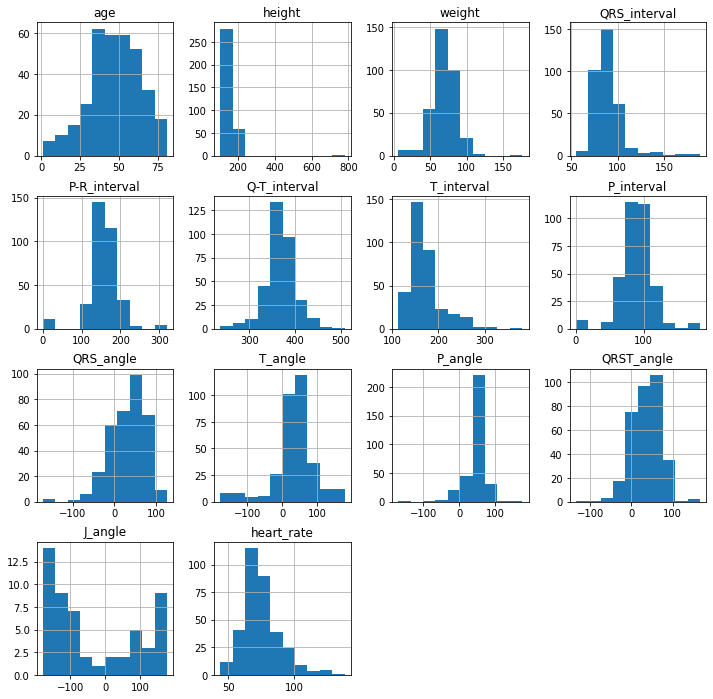

In [18]:
X_train.loc[:, X_train.columns!='sex'].hist(figsize=(12, 12));

Как минимум, в признаке 'height' есть выбросы (указан в сантиметрах)

In [19]:
data['height'].max()

780

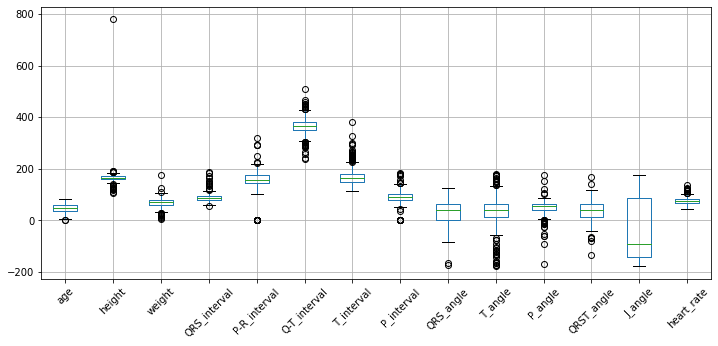

In [20]:
X_train.loc[:, X_train.columns!='sex'].boxplot(figsize=(12, 5), rot=45);

- **age**

In [21]:
# легкая левая ассиметрия
X_train['age'].skew(), X_train['age'].kurt()

(-0.3556750977854599, -0.17283886626102252)

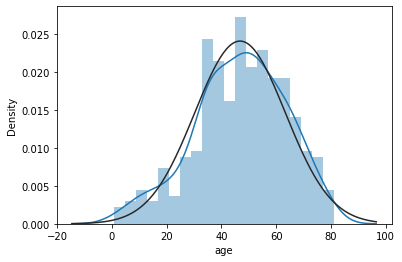

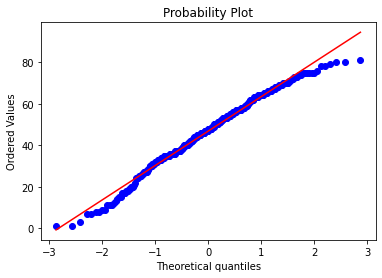

In [22]:
sns.distplot(X_train['age'], bins=20, fit=norm)
fig = plt.figure()
res = stats.probplot(X_train['age'], plot=plt)

In [23]:
X_train.loc[X_train['age'] == X_train['age'].min(), ['age', 'height', 'weight']]

,age,height,weight
170,1,780,6
219,1,110,10


In [24]:
X_train.loc[X_train['age'] == X_train['age'].max(), ['age', 'height', 'weight']]

,age,height,weight
302,81,165,60


max и min вполне правдоподобны.

- **height**

In [25]:
data.loc[data['height'] >= 220, ['age', 'height', 'weight']]

,age,height,weight
141,1,780,6
316,0,608,10


В описании датасета рост указан в сантиметрах, очевидно что для младенцев здесь - рост в миллиметрах.

- замена роста в см на мм:

In [26]:
X_train.loc[X_train['height'] >= 220, 'height'] = X_train['height']\
                                                            .loc[X_train['height'] >= 220] / 10
X_test.loc[X_test['height'] >= 220, 'height'] = X_test['height']\
                                                            .loc[X_test['height'] >= 220] / 10

In [27]:
X_test.loc[X_test['height'] < 100, ['age', 'height', 'weight']]

,age,height,weight
88,0,60.8,10


- **weight**

In [28]:
# острая вершина
X_train['weight'].skew(), X_train['weight'].kurt()

(0.2988115857398694, 5.234642845379571)

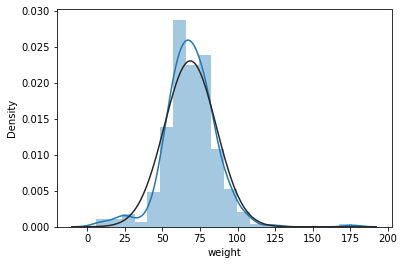

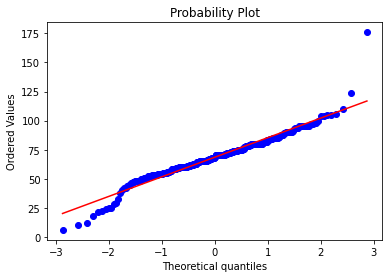

In [29]:
sns.distplot(X_train['weight'], bins=20, fit=norm)
fig = plt.figure()
res = stats.probplot(X_train['weight'], plot=plt)

<AxesSubplot: >

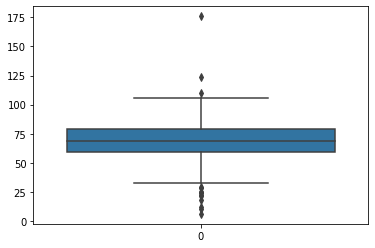

In [30]:
sns.boxplot(X_train['weight'], whis=1.5)

In [31]:
data.loc[data['weight'] < 25, ['age', 'height', 'weight']]

,age,height,weight
126,58,186,18
60,1,110,10
403,7,127,22
141,1,780,6
424,7,119,21
316,0,608,10
320,3,105,12
429,8,130,24


Кажется, что минимальные знаачения веса вполне правдоподобны, за исключением пациента с индексом 126.

- замена веса меньше 25 при возрасте > 15 на медиану

In [32]:
weight_med = X_train['weight'].median()

X_train.loc[(X_train['weight'] < 25) & (X_train['age'] > 15), 'weight'] = weight_med
X_test.loc[(X_test['weight'] < 25) & (X_test['age'] > 15), 'weight'] = weight_med

- замена веса выше 0.995 квантиля значением этого квантиля

In [33]:
q_995 = X_train['weight'].quantile(0.995)

In [34]:
X_train.loc[X_train['weight'] > q_995, 'weight'] = q_995
X_test.loc[X_test['weight'] > q_995, 'weight'] = q_995

- для оставшихся столбцов неочевидно, что является выбросом. Поэтому - просто распределения и м.б. преобразования, приближающие к нормальному распределению.

- **T_interval**

In [35]:
# правая ассиметрия
X_train['T_interval'].skew(), X_train['T_interval'].kurt()

(1.8682915164872202, 5.095347166949913)

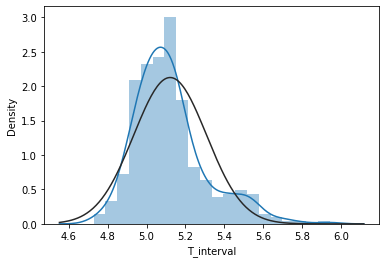

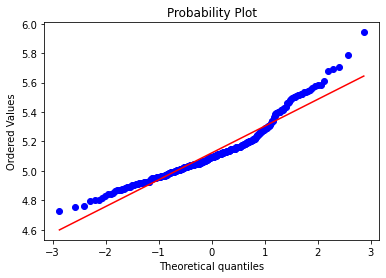

In [36]:
# логарифмическое преобразование немного уменьшает правую ассиметрию
sns.distplot(np.log(X_train['T_interval']), bins=20, fit=norm)
fig = plt.figure()
res = stats.probplot(np.log(X_train['T_interval']), plot=plt)

- новый признак **T_interval_log**

In [37]:
X_train['T_interval_log'] = np.log(X_train['T_interval'])
X_test['T_interval_log'] = np.log(X_test['T_interval'])

- Далее - 5 признаков с пропущенными значениями

In [38]:
X_train.isna().sum()

age                 0
sex                 0
height              0
weight              0
QRS_interval        0
P-R_interval        0
Q-T_interval        0
T_interval          0
P_interval          0
QRS_angle           0
T_angle             8
P_angle            15
QRST_angle          1
J_angle           285
heart_rate          1
T_interval_log      0
dtype: int64

In [39]:
col_with_nan = ['T_angle', 'P_angle', 'QRST_angle', 'heart_rate']
median_dict = {x: X_train[x].median() for x in col_with_nan}
median_dict

{'T_angle': 41.0, 'P_angle': 56.0, 'QRST_angle': 38.5, 'heart_rate': 73.0}

In [40]:
X_train[col_with_nan] = X_train[col_with_nan].fillna(median_dict)
X_test[col_with_nan] = X_test[col_with_nan].fillna(median_dict)

In [41]:
X_train.isna().sum()

age                 0
sex                 0
height              0
weight              0
QRS_interval        0
P-R_interval        0
Q-T_interval        0
T_interval          0
P_interval          0
QRS_angle           0
T_angle             0
P_angle             0
QRST_angle          0
J_angle           285
heart_rate          0
T_interval_log      0
dtype: int64

- **J_angle** - слишком много пропусков (больше половины) - удаление

In [42]:
X_train.drop('J_angle', axis=1, inplace=True)
X_test.drop('J_angle', axis=1, inplace=True)

###### Взаимосвязь признаков 

- корреляция переменных друг с другом и с таргетом.

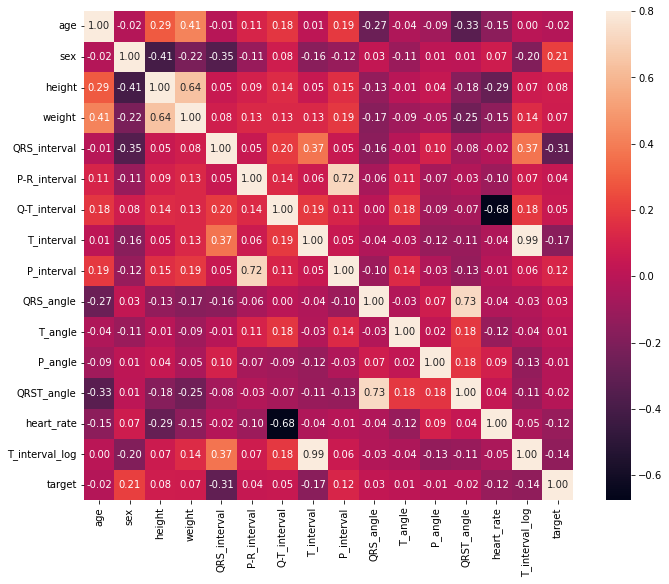

In [43]:
corrmat = pd.concat([X_train, y_train], axis=1).corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt='.2f');

За исключением ожидаемой высокой корреляции между T_interval_log и T_interval - чрезмерно высоких (низких) значений нет.

- взаимная информация

In [44]:
mutual_info = pd.DataFrame(mutual_info_classif(X_train, y_train), 
                           index=X_train.columns, columns=['mutual_info'])
mutual_info.sort_values('mutual_info', ascending=False)

,mutual_info
QRST_angle,0.130862
heart_rate,0.118527
QRS_interval,0.098615
T_interval,0.076842
T_angle,0.050877
weight,0.048374
T_interval_log,0.048035
sex,0.046293
height,0.042235
Q-T_interval,0.038610


Кажется, что имеет смысл комбинировать признаки пола и возраста с наиболее тесно связянными с таргетом показателями сердечной деятельности.

#### 3. сделать feature engineering

In [45]:
# бины для возраста
X_train['age_bin'] = X_train['age'] // 10
X_test['age_bin'] = X_test['age'] // 10

In [46]:
# 18 комбинаций для нового категориального признака
X_train[['age_bin', 'sex']].value_counts()

age_bin  sex
3        1      43
4        0      38
5        0      38
         1      38
4        1      36
6        1      33
3        0      22
6        0      19
2        1      16
7        1      12
         0      12
1        0       8
         1       7
0        0       6
2        0       5
0        1       3
8        0       2
         1       1
dtype: int64

In [47]:
X_train['age_sex'] = (X_train[['age_bin', 'sex']]
                      .apply(lambda comb: '_'.join([str(i) for i in comb]), axis=1))
X_train['age_sex'].value_counts()

3_1    43
5_1    38
5_0    38
4_0    38
4_1    36
6_1    33
3_0    22
6_0    19
2_1    16
7_0    12
7_1    12
1_0     8
1_1     7
0_0     6
2_0     5
0_1     3
8_0     2
8_1     1
Name: age_sex, dtype: int64

In [48]:
X_test['age_sex'] = (X_test[['age_bin', 'sex']]
                      .apply(lambda comb: '_'.join([str(i) for i in comb]), axis=1))

- средние  T_interval_log, QRS_angle, QRS_interval,  heart_rate по новым категориям.

In [49]:
new_col = ['T_interval_log', 'QRS_angle', 'QRS_interval', 'heart_rate']

bins_mean = []
for col in new_col:
    new_val = (X_train.groupby(['age_sex'])
                          .agg({col: 'mean'})
                          .rename(columns={col: f'{col}_per_age_sex'}))
    bins_mean.append(new_val)

In [50]:
bins_mean[3]

,heart_rate_per_age_sex
age_sex,
0_0,96.833333
0_1,113.333333
1_0,77.625000
1_1,87.000000
2_0,64.000000
2_1,73.125000
3_0,71.818182
3_1,74.790698
4_0,73.578947


Для комбинаций теста, которых нет на трейне - просто median() по всему столбцу
(но в тестовой выборке таких на самом деле нет)

In [51]:
med_for_gaps = [X_train[col].median() for col in new_col]
med_for_gaps

[5.093750200806762, 40.0, 86.0, 73.0]

In [52]:
for i in range(len(new_col)):
    X_train = X_train.merge(bins_mean[i], on=['age_sex'], how='left')
    X_test = X_test.merge(bins_mean[i], on=['age_sex'], how='left').fillna(med_for_gaps[i])

In [53]:
X_train.isna().sum().sum(), X_test.isna().sum().sum()

(0, 0)

###### Отбор признаков

снова взаимная информация

In [54]:
mutual_info = pd.DataFrame(mutual_info_classif(X_train, y_train), 
                           index=X_train.columns, columns=['mutual_info'])
mutual_info.sort_values('mutual_info', ascending=False)

,mutual_info
QRST_angle,0.107944
heart_rate,0.091954
T_angle,0.078237
QRS_angle,0.073721
age_sex,0.073514
QRS_interval,0.069479
heart_rate_per_age_sex,0.067183
age_bin,0.064687
QRS_angle_per_age_sex,0.063662
height,0.062407


Матрица корреляций

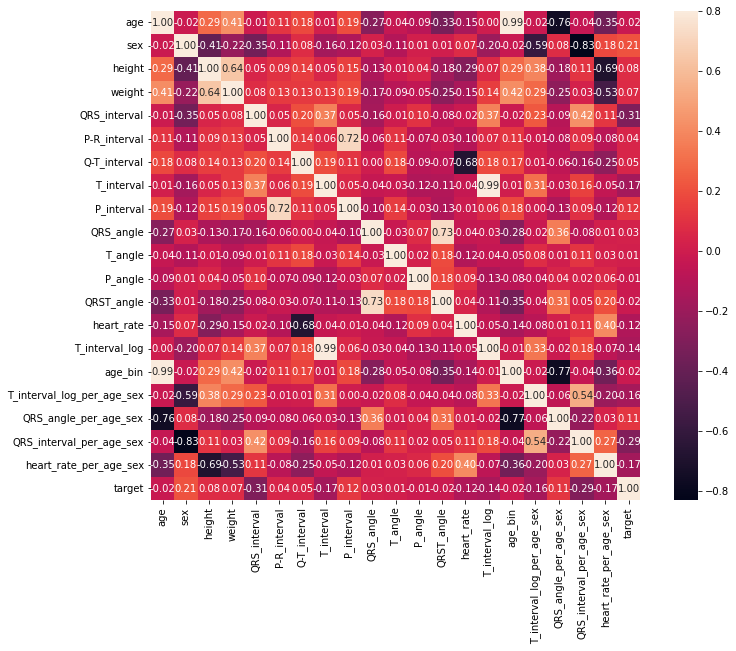

In [55]:
corrmat = pd.concat([X_train, y_train], axis=1).corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt='.2f');

Имеет смысл оставить из наиболее высоко коррелированных признаков те, которые более тесно связаны с таргетом.

- sex и QRS_interval_per_age_sex - высокая корреляция, но у пола большая взаимная инфорамция с таргетом, а 'QRS_interval_per_age_sex' сильнее коррелирует с таргетом, т.е. стоит посмотреть, как будут вести себя признаки в модели.

- T_interval и T_interval_log - то же самое

- P-R_interval слабо коррелирует с таргетом - и нулевая взаимная информация

In [56]:
features = ['age_bin', 'sex', 'height', 'weight', 'QRS_interval', 'Q-T_interval', 'T_interval',
            'P_interval', 'QRS_angle', 'T_angle', 'P_angle', 'QRST_angle', 'heart_rate',
            'T_interval_log', 'T_interval_log_per_age_sex', 'QRS_angle_per_age_sex', 
            'QRS_interval_per_age_sex', 'heart_rate_per_age_sex']
len(features)

18

In [57]:
X_train_new = X_train[features]
X_test_new = X_test[features]

In [58]:
X_train_new.shape, X_test_new.shape

((339, 18), (113, 18))

- рекурсивный отбор признаков

In [59]:
st_sc = StandardScaler()
X_train_st = st_sc.fit_transform(X_train_new)
X_test_st = st_sc.transform(X_test_new)

In [60]:
X_train_st.shape, X_test_st.shape

((339, 18), (113, 18))

In [61]:
selector = RFECV(LogisticRegression(random_state=42, max_iter=400), cv=5, scoring='roc_auc')
selector.fit(X_train_st, y_train)

RFECV(cv=5, estimator=LogisticRegression(max_iter=400, random_state=42),
      scoring='roc_auc')

In [62]:
X_train_new.iloc[:, selector.support_].columns

Index(['height', 'weight', 'QRS_interval', 'T_interval', 'P_interval',
       'QRS_angle', 'QRST_angle', 'heart_rate', 'T_interval_log',
       'QRS_angle_per_age_sex', 'QRS_interval_per_age_sex',
       'heart_rate_per_age_sex'],
      dtype='object')

In [63]:
new_col = ['height', 'weight', 'QRS_interval', 'T_interval', 'P_interval',
           'QRS_angle', 'QRST_angle', 'heart_rate', 'T_interval_log',
           'QRS_angle_per_age_sex', 'QRS_interval_per_age_sex',
           'heart_rate_per_age_sex']

In [64]:
# для точки отсчёта
lr = LogisticRegression(penalty='l1', C=1.6, solver='saga', max_iter=395, random_state=42)

lr.fit(X_train_st[:, selector.support_], y_train)
preds_lr = lr.predict_proba(X_test_st[:, selector.support_])[:, 1]

roc_auc, prec, rec, f_score, th = get_metrics(y_test, preds_lr)
print(f'roc_auc: {roc_auc:.4f}, prec: {prec:.4f}, rec: {rec:.4f},'
      f' f-score: {f_score:.4f}, th: {th:.4f}')

roc_auc: 0.7365, prec: 0.7126, rec: 0.9538, f-score: 0.8158, th: 0.3850


###### Pipeline

In [65]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1], 
                                                    data['target'], random_state=0)

In [66]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True);

In [67]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class PrunOutlier(BaseEstimator, TransformerMixin):
    def __init__(self, column, low, high):
        self.column = column
        self.low = low
        self.high = high
        self.median = 0

    def fit(self, X, y=None):
        self.median = np.median(X[self.column[0]])
        return self

    def transform(self, X):
        X_new = X[self.column].copy()
        X_new.loc[(X_new[self.column[0]] < self.high) & (X_new[self.column[1]] > self.low), 
                                                                  self.column[0]] = self.median
        return X_new[[self.column[0]]]
    
    
class NanFiller(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.median = 0

    def fit(self, X, y=None):
        self.median = X[self.key].median()
        return self

    def transform(self, X):
        X = X.fillna(self.median)
        return X[[self.key]]
    

class NumBins(BaseEstimator, TransformerMixin):
    def __init__(self, bin_col, num_col):
        self.bin_col = bin_col
        self.num_col = num_col
        self.median = 0

    def fit(self, X, y=None):
        self.median = X[self.num_col].median()
        return self

    def transform(self, X):
        X_new = X.copy()
        X_new[self.num_col] = X_new[self.num_col].fillna(self.median)
        
        X_new['new_cat'] = (X_new[self.bin_col]
                            .apply(lambda comb: '_'.join([str(i) for i in comb]), axis=1))
        
        new_feat = f'{self.num_col}_per_{"_".join(self.bin_col)}'
        new_val = (X_new.groupby(['new_cat'])
                          .agg({self.num_col: 'mean'})
                          .rename(columns={self.num_col: new_feat}))
        X_new = X_new.merge(new_val, on=['new_cat'], how='left').fillna(self.median)
        return X_new[[new_feat]]

In [68]:
# замена мм на см
def to_cm(X, bord, key):
    X_new = X.copy()
    X_new.loc[X_new[key] > bord] = X_new.loc[X_new[key] > bord] / 10
    return X_new

In [69]:
all_transformers = []
# height > 220 / 10
height_transf = Pipeline([
                ('selector', NumberSelector(key='height')),
                ('transformer', FunctionTransformer(to_cm, kw_args={'bord': 220, 'key': 'height'})),
#                 ('standard', StandardScaler())
            ])
all_transformers.append(('height', height_transf))

# weight < 25 & age > 15 - замена weight на median
weight_transf = Pipeline([
                ('selector', FeatureSelector(column=['weight', 'age'])),
                ('w_transf', PrunOutlier(column=['weight', 'age'], low=15, high=25))
#                 ('standard', StandardScaler())
            ])
all_transformers.append(('weight', weight_transf))

# без изменений
base_cols = ['QRS_interval', 'T_interval', 'P_interval', 'QRS_angle']
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col)),
#                 ('standard', StandardScaler())
            ])
    all_transformers.append((base_col, base_transformer))

# заполнение пропусков
cols_with_nan = ['QRST_angle', 'heart_rate']
for col_nan in cols_with_nan:
    nan_transformer = Pipeline([
                ('selector', NumberSelector(key=col_nan)),
                ('nan_transf', NanFiller(key=col_nan)),
#                 ('standard', StandardScaler())
            ])
    all_transformers.append((col_nan, nan_transformer))

# T_interval_log
log_transf = Pipeline([
                ('selector', NumberSelector(key='T_interval')),
                ('log_transformer', FunctionTransformer(np.log)), 
#                 ('standard', StandardScaler())
            ])
all_transformers.append(('T_interval_log', log_transf))


# per_age_sex
per_age_sex_cols = ['QRS_angle', 'QRS_interval', 'heart_rate']
for col in per_age_sex_cols:
    per_age_sex_transf = Pipeline([
                    ('selector', FeatureSelector(column=['sex', 'age', col])),
                    ('NumBins', NumBins(bin_col=['sex', 'age'], num_col=col)),
    #                 ('standard', StandardScaler())
                ])
    all_transformers.append((f'{col}_per_age_sex', per_age_sex_transf))

feats = FeatureUnion(all_transformers)

In [70]:
X_train = feats.fit_transform(X_train)
X_test = feats.transform(X_test)

#### 4. обучить любой классификатор (какой вам нравится)

In [71]:
lgb_model = LGBMClassifier(random_state=42, learning_rate=0.02, max_depth=10)
lgb_model.fit(X_train, y_train)

preds_lgb = lgb_model.predict_proba(X_test)[:, 1]

roc_auc, prec, rec, f_score, th = get_metrics(y_test, preds_lgb)
print(f'roc_auc: {roc_auc:.4f}, prec: {prec:.4f}, rec: {rec:.4f},'
      f' f-score: {f_score:.4f}, th: {th:.4f}')

roc_auc: 0.7846, prec: 0.7108, rec: 0.9077, f-score: 0.7973, th: 0.2711


#### 5. разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)

In [72]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)[1]

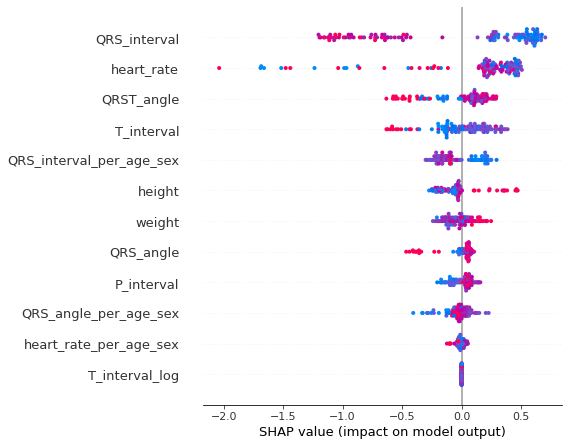

In [78]:
# какой-то конфликт с matplotlib и местом для осей, поэтому color_bar=False
shap.summary_plot(shap_values, X_test, feature_names=new_col, color_bar=False)

- Наибольшее влияние на предсказание вероятности 1 класса (отсутствие аритмии) оказывает признак **QRS_interval**, при этом низкие значения увеличивают вероятность здоровья, высокие - какого-то из типов аритмии.
- **heart_rate** - влияет как на увеличение вероятности 1 класса, так и на вероятность 0  класса
- низкие значения **QRST_angle** скорее понижают вероятность 1 класса
- **T_interval** - высокие значения влияют как на вероятность класса 0, так и класса 1,
но очень низкие значения чаще у класса 0, а средние (фиолетовый маркер) - у класса 1.
- **QRS_interval_per_age_sex** - высокие значения увеличивают вероятность аритмии, низкие - здоровья.
- высокий рост скорее положительно влияет на вероятность целевого класса, низкий - отрицательно.
- вес - точно так же.

Но тут стоит помнить, что группа смешанная - включает взрослых, детей, мужчин и женщин - а у разных групп свои нормальные показатели сердечной деятельности и свои особенности отклонений. Здесь скорее низкий рост и вес => ребёнок или женщина => более высокий heart_rate, который чаще бывает при аритмии (но не всех видах аритмии).

- для топ 10%

In [74]:
perc = int(len(preds_lgb)*0.1)
top10_idx = pd.Series(preds_lgb).sort_values(ascending=False).index[:perc]
top10_idx

Int64Index([28, 47, 48, 63, 77, 90, 98, 83, 75, 6, 36], dtype='int64')

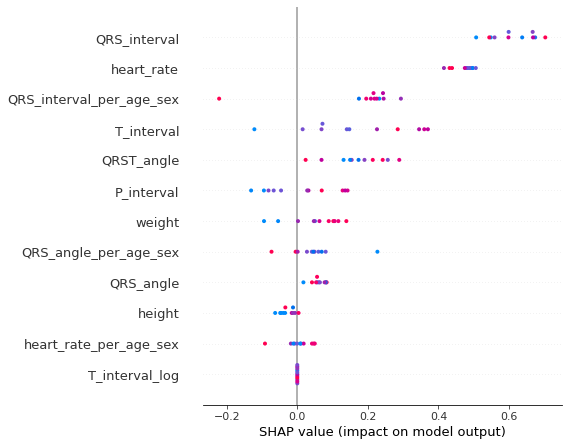

In [75]:
shap.summary_plot(shap_values[top10_idx], 
                  X_test[top10_idx], 
                  feature_names=new_col, 
                  color_bar=False)

Для top10 наиболее здоровых (по предсказанию модели) в принципе сохраняются все закономерности. Но учитывая, что таких всего 11 человек, общий вывод менее очевиден. 
- **QRS_interval** оказывает наиболее сильное влияние на повышение вероятности класса 1, но здесь в позитивную сторону работают и низкие и средние и высокие значения. То же самое и для **heart_rate** и большинства других признаков. Т.е. - должна быть связь с другими факторами.
- средне-высокие и высокие значения **P_interval** - повышают вероятность целевого класса, низкие и средние - понижают. 

Т.е. в выборке имеются разнородные группы, на которые факторы действуют по-разному.

- высокие значения веса повышают, а низкие - понижают вероятность класса 1.

- а с ростом - интересно, что в top10 выборке оказались те, для кого низкий и средний рост немного понижает вероятность быть здоровым. 

#### 6. для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [80]:
shap.plots.force(explainer.expected_value[1], 
                 shap_values[:10], 
                 features=X_train[:10], 
                 feature_names=new_col)

Наибольшее влияние на таргет оказывают **QRS_interval** и **heart_rate**, при этом определённые значения QRS_interval также повышают и вероятность класса 0. Достаточно большое влияние на увеличение вероятности аритмии оказывает признак **hight**. При этом признаки взаимодействуют друг с другом достаточно сложным образом (так, например, для признаков **P_interval**, **T_interval** и др нет чётких взаимосвязей с таргетом), и вероятнее всего, в выборке имеются разнородные группы, на которые факторы действуют по-разному.

In [81]:
shap.plots.force(explainer.expected_value[1], 
                 shap_values[top10_idx], 
                 features=X_train[top10_idx], 
                 feature_names=new_col)

Интересна диаграмма для top10, где большая часть признаков позитивно влияет на вероятность класса 1. При этом hear_rate не ниже 70, QRS_interval не ниже 80.